In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

import pdb
from tqdm import tqdm

from bayesnn.models.bbb_het_reg import BBBHetRegModel

%matplotlib inline

In [16]:
from scipy import stats

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
def true_f(x, e=0):
    return x + 0.3 * np.sin(2 * np.pi * (x + e)) + 0.3 * np.sin(4. * np.pi * (x + e))
    #return np.sin(12.0 * x) + 0.66 * np.cos(25.0 * x) + 3.0
    #return np.sin(x)


def get_data(train_size=100, test_size=100):
    n = train_size + test_size

    np.random.seed(42)

    #X = np.linspace(-2.0, 2.0, num=n)
    X = np.random.uniform(-1.0, 1.0, n)
    e = np.random.normal(0, 0.02, n)
    Y = true_f(X, e=e) + e

    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

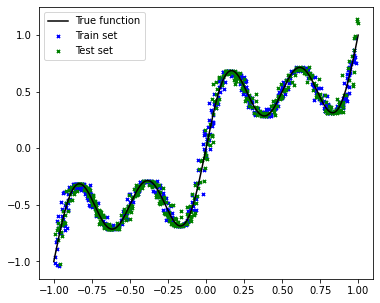

In [4]:
true_x = np.linspace(-1.0, 1.0, 1000)
true_y = true_f(true_x, e=0)

X_train, y_train, X_test, y_test = get_data(500, 500)

plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_train, y_train, s=10, marker='x', color='blue', label='Train set')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.legend()

plt.show()

In [7]:
n_hidden = 5

model_reg = BBBHetRegModel(hidden_size=n_hidden, act_func=F.tanh).to(device)

params_reg = list(model_reg.parameters())
optimizer_reg = torch.optim.Adam(params_reg, lr=0.01)

X_train_tensor = torch.from_numpy(X_train.reshape((-1, 1))).float().to(device)
y_train_tensor = torch.from_numpy(y_train.reshape((-1, 1))).float().to(device)

X_test_tensor = torch.from_numpy(X_test.reshape((-1, 1))).float().to(device)
y_test_tensor = torch.from_numpy(y_test.reshape((-1, 1))).float().to(device)

loss_fn = nn.MSELoss()

In [8]:
num_epoches = 3000
num_samples = 10

model_reg.train(True)

for ep in tqdm(range(1, num_epoches+1)):
    optimizer_reg.zero_grad()
    log_likelihood_total = 0
    kl = model_reg.get_kl()

    for i in range(num_samples):
        out_mu, out_sigma = model_reg(X_train_tensor, sample=True)

        log_likelihood = torch.distributions.Normal(loc=out_mu, scale=out_sigma).log_prob(y_train_tensor).sum()
        log_likelihood_total += log_likelihood

    #elbo = (log_likelihood_total - kl_total) / (num_samples * x_train.shape[0])
    log_likelihood_total_s = log_likelihood_total / num_samples
    elbo = log_likelihood_total_s - kl
    (-elbo).backward()

    optimizer_reg.step()
    #optimizer_reg.zero_grad()

    if ep % 50 == 0:
        print(f'Epoch {ep} | '
              f'ELBO {elbo.cpu().detach().numpy()} | '
              f'LL {log_likelihood_total_s.cpu().detach().numpy()} | '
              f'KL {kl.cpu().detach().numpy() if isinstance(kl, torch.Tensor) else kl}')

        with torch.no_grad():
            y_pred, _ = model_reg(X_test_tensor, sample=False)
            mse = loss_fn(y_pred, y_test_tensor).mean().cpu().detach().numpy()

        print(f"MSE {mse}")

100%|██████████| 3000/3000 [02:41<00:00, 18.55it/s]


Epoch 50 | ELBO -690.1799926757812 | LL -49.203819274902344 | KL 640.9761962890625
MSE 0.08259930461645126
Epoch 100 | ELBO -645.1961669921875 | LL -30.078903198242188 | KL 615.1172485351562
MSE 0.07829064875841141
Epoch 150 | ELBO -546.4310302734375 | LL 43.71381759643555 | KL 590.1448364257812
MSE 0.056455496698617935
Epoch 200 | ELBO -404.7941589355469 | LL 162.23989868164062 | KL 567.0340576171875
MSE 0.03171827271580696
Epoch 250 | ELBO -297.0148010253906 | LL 247.85067749023438 | KL 544.865478515625
MSE 0.022649073973298073
Epoch 300 | ELBO -247.62210083007812 | LL 272.9881286621094 | KL 520.6102294921875
MSE 0.0218754131346941
Epoch 350 | ELBO -196.28353881835938 | LL 299.5637512207031 | KL 495.8472900390625
MSE 0.02214287407696247
Epoch 400 | ELBO -152.16439819335938 | LL 318.79705810546875 | KL 470.9614562988281
MSE 0.02171524614095688
Epoch 450 | ELBO -110.39163208007812 | LL 335.5550842285156 | KL 445.94671630859375
MSE 0.02084103412926197
Epoch 500 | ELBO -72.47821044921875

In [19]:
n_samples = 100
model_reg.train(False)

true_x_tensor = torch.from_numpy(true_x.reshape((-1, 1))).float().to(device)
#true_y_tensor = torch.from_numpy(true_y_train.reshape((-1, 1))).float().to(device)

samples_m = np.zeros((true_x_tensor.shape[0], n_samples))
samples_s = np.zeros_like(samples_m)
for i in range(n_samples):
    mus, sigmas = model_reg(true_x_tensor, sample=False)
    np_m = mus.cpu().data.numpy()
    np_s = sigmas.cpu().data.numpy()
    samples_m[:, i] = np_m[:, 0]
    samples_s[:, i] = np_s[:, 0]

y_pred_mean = samples_m.mean(axis=1)
y_pred_std = samples_s.mean(axis=1)

ti = stats.t(df=num_samples - 1).ppf((0.025, 0.975))
y_err = ti[1] * y_pred_std / np.sqrt(1. + 1. / num_samples)

print(model_reg(torch.tensor([[-1.0], [0.0], [1.0]], device=device), sample=False))

C:\Users\Alex\anaconda3\envs\bayesnn\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(tensor([[-0.4151],
        [ 0.0239],
        [ 0.5535]], grad_fn=<SliceBackward>), tensor([[0.2313],
        [0.1349],
        [0.1438]], grad_fn=<AddBackward0>))


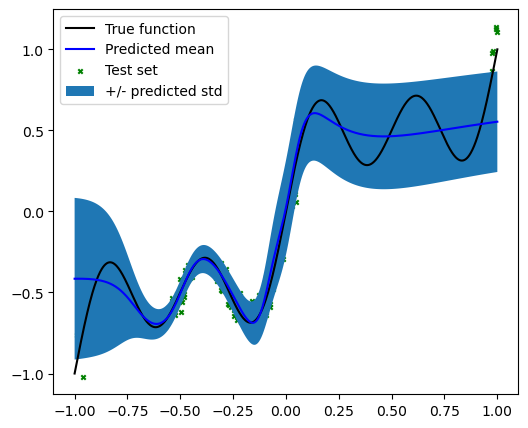

In [20]:
plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.plot(true_x, y_pred, color='blue', label='Predicted mean')
plt.fill_between(true_x, y_pred-y_err, y_pred+y_err, label='+/- predicted std')

#plt.scatter(X_test, y_pred, s=10, marker='o', label='Predictions')
#plt.errorbar(X_test, y_pred, yerr=y_err, fmt='o', ls='none', label='Predictions')


plt.legend()

plt.show()

In [20]:
model_simple =  nn.Sequential(
          nn.Linear(1, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, 1)
        ).to(device)

class Reg2L(nn.Module):
    def __init__(self, n_hidden=10, act_func=F.tanh):
        super().__init__()
        self.n_hidden = n_hidden
        self.act_func = act_func
        self.layer1 = nn.Linear(1, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, 2)

    def forward(self, input):
        h1 = self.layer1(input)
        h2 = self.layer2(self.act_func(h1))
        h3 = self.layer3(self.act_func(h2))
        m = h3[:, :1]
        s = F.elu(h3[:, 1:]) + 1.
        return m, s

class Reg2N(nn.Module):
    def __init__(self, n_hidden=10, activation=nn.ReLU):
        super().__init__()
        self.n_hidden = n_hidden
        self.activation = activation
        self.mu_net = nn.Sequential(
            nn.Linear(1, n_hidden),
            activation(),
            nn.Linear(n_hidden, n_hidden),
            activation(),
            nn.Linear(n_hidden, 1)
        )

        self.sigma_net = nn.Sequential(
            nn.Linear(1, n_hidden),
            activation(),
            nn.Linear(n_hidden, n_hidden),
            activation(),
            nn.Linear(n_hidden, 1),
            nn.Softplus()
        )

    def forward(self, input):
        return self.mu_net(input), self.sigma_net(input)

model_simple = Reg2L(n_hidden=n_hidden, act_func=F.relu).to(device)
optimizer_simple = torch.optim.Adam(model_simple.parameters(), lr=0.01)

In [21]:
num_epoches = 3000

for ep in tqdm(range(num_epoches)):
    optimizer_simple.zero_grad()

    mu, sigma = model_simple(X_train_tensor)
    #sigma = 1.0
    loss = - torch.distributions.Normal(mu, sigma).log_prob(y_train_tensor).sum()

    loss.backward()

    optimizer_simple.step()

    if (ep + 1) % 50 == 0:
        #print(f'ELBO value is {elbo.cpu().detach().numpy()} on epoch number {ep}')

        with torch.no_grad():
            y_pred, _ = model_simple(X_test_tensor)
            mse = loss_fn(y_pred, y_test_tensor).to(torch.float32).cpu().mean().numpy()

        print(f"Epoch {ep} MSE {mse}")

100%|██████████| 3000/3000 [00:13<00:00, 219.59it/s]


Epoch 49 MSE 0.05769817531108856
Epoch 99 MSE 0.028818385675549507
Epoch 149 MSE 0.022903237491846085
Epoch 199 MSE 0.022440308704972267
Epoch 249 MSE 0.022236071527004242
Epoch 299 MSE 0.022204723209142685
Epoch 349 MSE 0.02225394733250141
Epoch 399 MSE 0.022330347448587418
Epoch 449 MSE 0.022443484514951706
Epoch 499 MSE 0.022265268489718437
Epoch 549 MSE 0.022469444200396538
Epoch 599 MSE 0.02246340550482273
Epoch 649 MSE 0.022693436592817307
Epoch 699 MSE 0.022442765533924103
Epoch 749 MSE 0.02261163666844368
Epoch 799 MSE 0.022527145221829414
Epoch 849 MSE 0.022709878161549568
Epoch 899 MSE 0.022550813853740692
Epoch 949 MSE 0.02257147803902626
Epoch 999 MSE 0.022675707936286926
Epoch 1049 MSE 0.022631928324699402
Epoch 1099 MSE 0.022493261843919754
Epoch 1149 MSE 0.02249404974281788
Epoch 1199 MSE 0.022557582706212997
Epoch 1249 MSE 0.02251945622265339
Epoch 1299 MSE 0.02251007780432701
Epoch 1349 MSE 0.022634699940681458
Epoch 1399 MSE 0.022480715066194534
Epoch 1449 MSE 0.02250

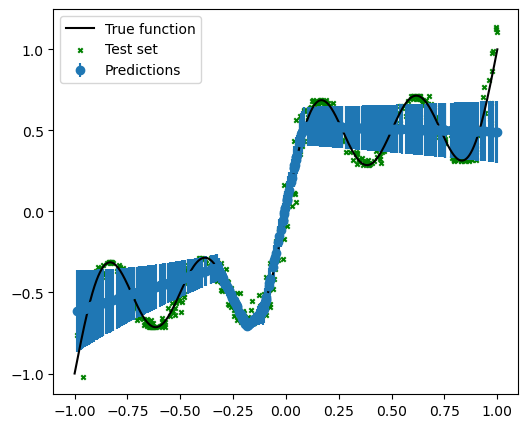

(tensor([[-0.6175],
        [ 0.0380],
        [ 0.4918]], grad_fn=<SliceBackward>), tensor([[0.2586],
        [0.1085],
        [0.1918]], grad_fn=<AddBackward0>))


In [22]:
y_pred, sigma_pred = map(lambda x: x.cpu().data.numpy()[:, 0], model_simple(X_test_tensor))

plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.errorbar(X_test, y_pred, yerr=sigma_pred, ls='none', marker='o', label='Predictions')

plt.legend()

plt.show()

print(model_simple(torch.tensor([[-1.0], [0.0], [1.0]], device=device)))

In [ ]:
w1 = model_simple._modules['0'].weight.data
b1 = model_simple._modules['0'].bias.data

w2 = model_simple._modules['2'].weight.data
b2 = model_simple._modules['2'].bias.data

w3 = model_simple._modules['4'].weight.data
b3 = model_simple._modules['4'].bias.data

In [107]:
def copy_weights2(m1, m2):
    m2.layer1.W_mu.data = m1.layer1.weight.data
    m2.layer1.bias_mu.data = m1.layer1.bias.data

    m2.layer2.W_mu.data = m1.layer2.weight.data
    m2.layer2.bias_mu.data = m1.layer2.bias.data

    m2.layer3.W_mu.data[0:0, ] = m1.layer3.weight.data
    m2.layer3.bias_mu.data[0] = m1.layer3.bias.data[0]

In [108]:
copy_weights2(model_simple, model_reg)

In [ ]:
w1_b = model_reg.layer1.W_mu.cpu().data.numpy()
w2_b = model_reg.layer2.W_mu.cpu().data.numpy()
w3_b = model_reg.layer3.W_mu.cpu().data.numpy()

b1_b = model_reg.layer1.bias_mu.cpu().data.numpy()
b2_b = model_reg.layer2.bias_mu.cpu().data.numpy()
b3_b = model_reg.layer3.bias_mu.cpu().data.numpy()
